# Imaging and Quantifying F-actin bundles in the cortex of mammalian oocytes
## Computing image score
### Single image processing

In this part one will explain how to load a single tif image in python, and compute its bundling score.
- First, the image is loaded in python using `scikit-image`.
- Then, the image is cropped using the provided ROI.
- Finally, the bundling score is computed using the function `compute_score`.
- We don't use picture metadata, so the score is given in $\textrm{px}^2$. One has to multiply by the square of the resolution to get it in $\mu \textrm{m}^2$.

In [1]:
from skimage import io
from read_roi import read_roi_zip

import bundling_score.bundling_score as bs
import bundling_score.tools as bt

example_file = 'img/cortex_single_image.tif'
roi_file = 'img/roi.tif.zip'

dx = 0.1 #um/px

# Load the image and the ROI
image = io.imread(example_file).astype(float)
roi = read_roi_zip(roi_file)

# Crop the image to keep only the ROI
image = bt.crop_fiji_roi(image, roi)

# Compute the bundling score
score = bs.compute_score(image, smax=10)
print(f"The score of this image is {score*dx**2:.2e} um^2.")

The score of this image is 3.55e-02 um^2.


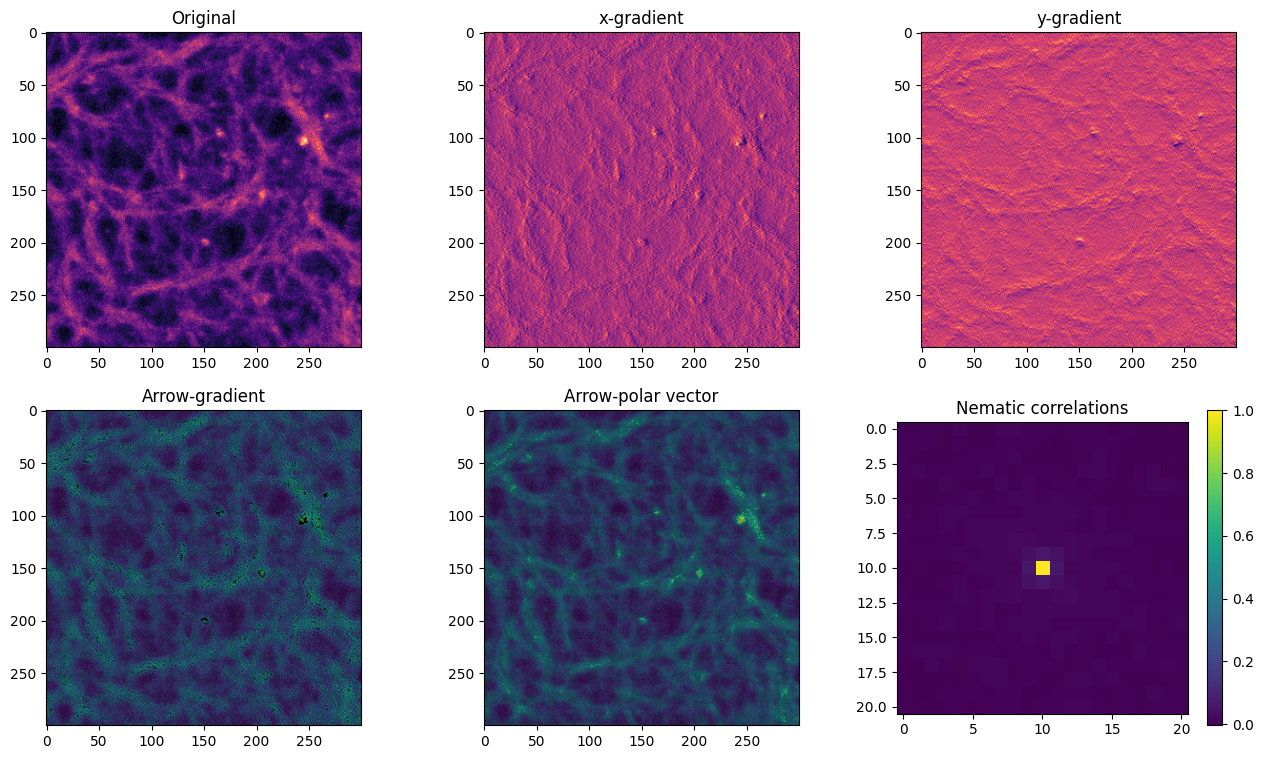

In [2]:
import bundling_score.plots as bp

bp.show_steps(image, smax=10)

### Timelapse processing
A timelapse can be processed in the same way, storing all scores in a list for example.



Text(0, 0.5, 'Bundling score (um^2)')

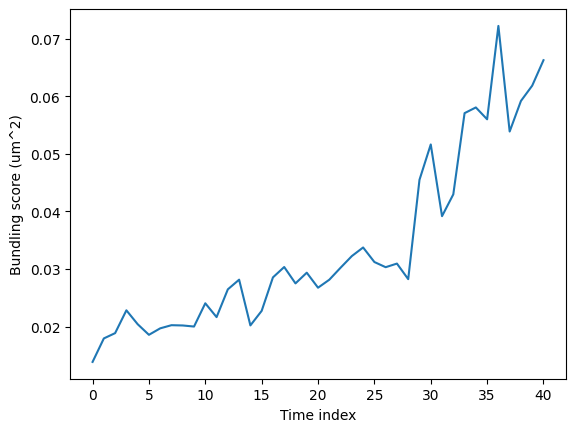

In [3]:
import matplotlib.pyplot as plt

example_file = 'img/cortex_timelapse.tif'
roi_file = 'img/roi.tif.zip'

dx = 0.1 #um/px

ic = io.MultiImage(example_file, dtype=float)
timelapse = ic[0] # Only one timelapse
roi = read_roi_zip(roi_file)
timelapse = bt.crop_fiji_roi(timelapse, roi)

scores = []
for i in range(timelapse.shape[0]):
    scores.append(bs.compute_score(timelapse[i, ...], smax=20)*dx**2)

plt.plot(scores)
plt.xlabel("Time index")
plt.ylabel("Bundling score (um^2)")

### Folder processing
Scikit-image image collection tools can be used to process a whole folder. In this example, all `tif` files in the `source` directory will be processed.

One uses `pandas` to create a DataFrame and create a csv file with headers.

   2021_12_15_2_GFP6-1  2021_12_15_2_GFP6-2
0             0.015818             0.020242
1             0.017228             0.022730
2             0.020303             0.032247
3             0.008818             0.039178
4             0.010787             0.061845


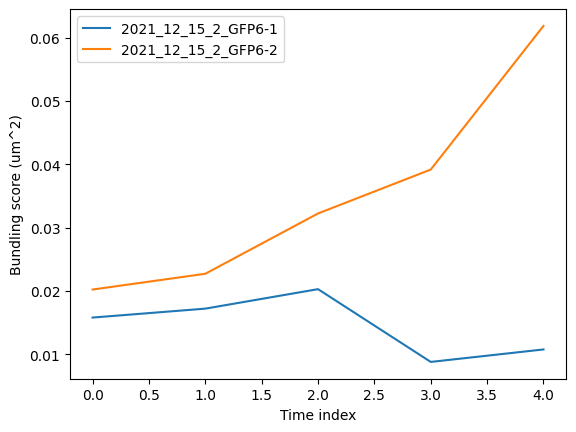

In [4]:
import pandas as pd

source_dir = 'img/source/'
ic = io.MultiImage(source_dir + '*.tif', dtype=float)

# Bundling scores will be stored in a DataFrame
df = pd.DataFrame()

for i, timelapse in enumerate(ic):
    # Get only the name of the file
    name = ic.files[i][len(source_dir):-4]
    # Load ROI and crop
    roi = read_roi_zip(source_dir+'sub_'+name+'.tif.zip')
    timelapse = timelapse.astype(float)
    timelapse = bt.crop_fiji_roi(timelapse, roi)
    
    scores = []
    
    for j in range(timelapse.shape[0]):
        scores.append(bs.compute_score(timelapse[j, ...], smax=20)*dx**2)
    plt.plot(scores, label=name)
    

    # Header is the name of the tif file
    series = pd.Series(scores, name=name)
    # Add to the main dataframe
    df = pd.concat((df, series), axis=1)

plt.legend()
plt.xlabel('Time index')
plt.ylabel('Bundling score (um^2)')

print(df)
# Save as csv
df.to_csv(source_dir + 'bundling_scores.csv')

## Tweaking parameters
This plugin has to parameters the user can chose: the correlation window size and the normalization.
### Correlation window size
The bundling score is based on the spatial correlations of the nematic tensor. Correlations are computed in a certain window, that needs to be less than half of the image size.

A larger window will unable to compute correlations between points that are farther away one from another. As a counterpart, this will increase noise in the bundling score.

A way to chose a good window size can be to compute the bundling score for a range of window size from 1 to half the size of the cropped image. We can see that the bundling score increases with the window size, reaches a plateau and then becomes more and more noisy. A good choice is to stop before one can see noise. In the example below, the red curve seems to become noisy around 20px, so we chose a window size of 20.

This should be done on a timelapse with a variety of bundling scores, to explore different levels of noise.

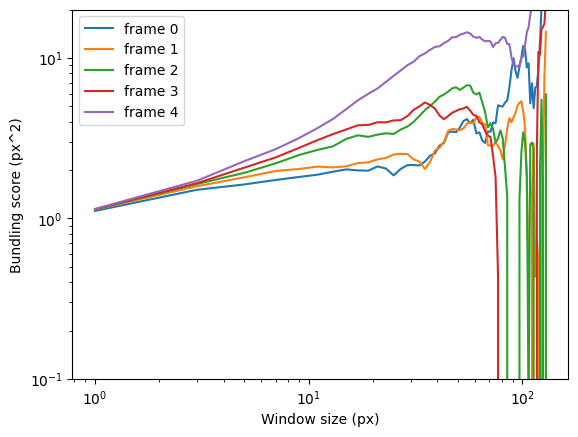

In [5]:
import numpy as np

# The first image had a low bundling score and the last image a high score
windows = np.arange(1, 130, 2, dtype=int)
for i, image in enumerate(timelapse):
    scores = []
    for smax in windows:
        scores.append(bs.compute_score(image, smax))
    plt.plot(windows, scores, label =f'frame {i}')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,20)
plt.xlabel('Window size (px)')
plt.ylabel('Bundling score (px^2)')
plt.legend()

### Normalization of the nematic tensor
The nematic tensor is defined from gradients of the image intensity $I(r)$.
$$ q_{ij} = \frac{\delta_{ij}/2-\partial_i I\partial_j I}{||\nabla I||^2}$$

In our paper, we multiplied by the intensity of the image $I(r)$.
$$ Q_{ij} = I(r) \frac{\delta_{ij}/2-\partial_i I\partial_j I}{||\nabla I||^2}$$
This is done to get more signal in places where there is more information (higher intensity). Because of camera noise, even parts of the image without bundles will have gradients, but the intensity is very low so they are disregarded.

Our script can use both normalizations through the optional argument `normalization`, that can be set to `none` or `intensity`. In the following, the two normalizations are compared. First, we can see that multiplying by intensity slightly increases the bundling score in standard images. Then, one add randoms spots to simulate artifacts. One sees that in such conditions, it is more robust to use the first definition of $q_{ij}$.

Because of robustness to artifacts, the default normalization is now set to `none`.

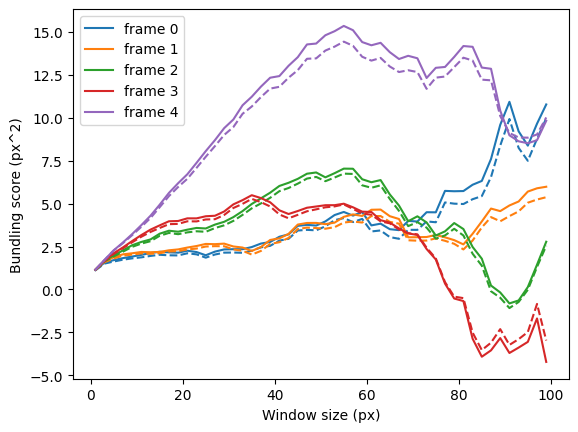

In [6]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)
    
# The first image had a low bundling score and the last image a high score
windows = np.arange(1, 100, 2, dtype=int)
for i, image in enumerate(timelapse):
    scores_int = []
    scores_none = []
    for smax in windows:
        scores_int.append(bs.compute_score(image, smax, normalization='intensity'))
        scores_none.append(bs.compute_score(image, smax, normalization='none'))
    plt.plot(windows, scores_int, label =f'frame {i}', color=colors[i])
    plt.plot(windows, scores_none, '--', color=colors[i])

plt.xlabel('Window size (px)')
plt.ylabel('Bundling score (px^2)')
plt.legend()

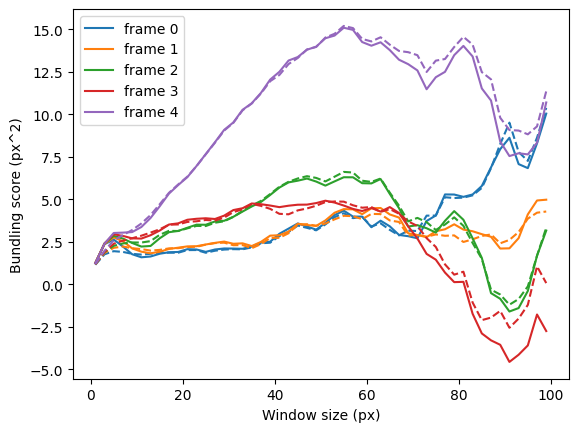

In [7]:
import numpy.random as rd
from skimage.filters import gaussian
from skimage.draw import disk

rad = image.shape[0]//2
n = 10
spot_mean_rad = 5

# Create random spots that will be added to the image
x_spot = rd.randint(0, 2 * rad, n)
y_spot = rd.randint(0, 2 * rad, n)
spots = np.zeros_like(image)

for j in range(n):
    spot_rad = rd.poisson(spot_mean_rad)
    rr, cc = disk((x_spot[j], y_spot[j]),
                  spot_rad,
                  shape=spots.shape)
    spots[rr, cc] = 1
spot_int = np.max(image)
spots = spot_int * gaussian(spots, sigma=1)
    
for i, image in enumerate(timelapse):
    image = image.astype(float)
    image += spots
    scores_int = []
    scores_none = []
    for smax in windows:
        scores_int.append(bs.compute_score(image, smax, normalization='intensity'))
        scores_none.append(bs.compute_score(image, smax, normalization='none'))
    plt.plot(windows, scores_int, label =f'frame {i}', color=colors[i])
    plt.plot(windows, scores_none, '--', color=colors[i])

plt.xlabel('Window size (px)')
plt.ylabel('Bundling score (px^2)')
plt.legend()

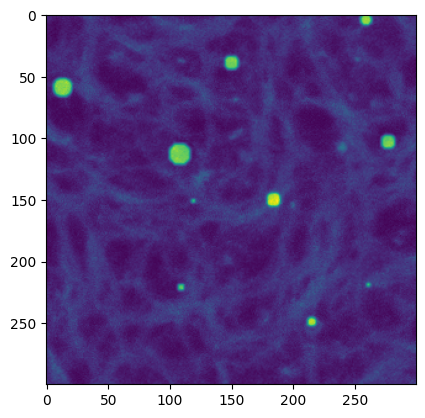

In [8]:
plt.imshow(image)